<a href="https://colab.research.google.com/github/Adricarpin/TensorFlow-notebooks/blob/master/NLP/Sentiment_analysis_womens_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [ ]:
! pip install kaggle


In [ ]:
! mkdir ~/.kaggle


In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews

  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 92.1MB/s]


In [ ]:
! unzip womens-ecommerce-clothing-reviews.zip

Archive:  womens-ecommerce-clothing-reviews.zip
  inflating: Womens Clothing E-Commerce Reviews.csv  


# Preprocessing

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [ ]:
df = df[['Review Text', 'Rating']]

In [ ]:
len(df)

23486

In [ ]:
df.dropna(inplace=True)

In [ ]:
len(df)

22641

In [ ]:
review = df['Review Text'].to_numpy()
rating = df['Rating'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(review, rating, test_size=0.2, stratify=rating)

# Tokenization

## Token vector size

In [ ]:
sent_lens = [len(i.split()) for i in train_X]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

60.26695008833922

(array([1324., 2897., 3220., 2957., 2338., 3573., 1803.]),
 array([  2.        ,  18.14285714,  34.28571429,  50.42857143,
         66.57142857,  82.71428571,  98.85714286, 115.        ]),
 <a list of 7 Patch objects>)

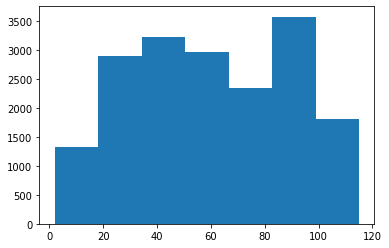

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7)

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

101

## Vocab size

In [ ]:
len(set(' '.join(train_X).split(" ")))

35777

## TextVectorization

In [ ]:
from tensorflow.keras.layers import TextVectorization


vocab_dim = 30000
token_vector_len = 100

text_vectorizer = TextVectorization(max_tokens = vocab_dim, # how many words in the vocabulary (all of the different words in your text)
                                    output_sequence_length=token_vector_len) # how long should the output sequence of tokens be?


In [ ]:
text_vectorizer.adapt(train_X)

In [ ]:
train_X_tokenized = text_vectorizer(train_X)
test_X_tokenized = text_vectorizer(test_X)

# Labels to OneHot

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
enc.fit(train_y.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [ ]:
train_y_encoded = enc.transform(train_y.reshape(-1,1))
test_y_encoded = enc.transform(test_y.reshape(-1,1))

In [ ]:
num_categories = np.size(enc.categories_)

# Subset

In [ ]:
make_split_train = int(0.1*len(train_X_tokenized))
train_X_mini = train_X_tokenized[:make_split_train]
train_y_mini = train_y_encoded[:make_split_train]

In [ ]:
make_split_test = int(0.1*len(test_X_tokenized))
test_X_mini = test_X_tokenized[:make_split_test]
test_y_mini = test_y_encoded[:make_split_test]

# Modelo 1 (LSTM 10% data)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

In [ ]:
embedding = layers.Embedding(input_dim=vocab_dim, 
                             output_dim=128, 
                             input_length=token_vector_len) 

In [ ]:
input = layers.Input(shape=(token_vector_len,))
x = embedding(input)
x = layers.LSTM(128)(x)
output = layers.Dense(num_categories, activation='softmax')(x)

model = Model(input, output)

In [ ]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [ ]:
history = model.fit(train_X_mini, train_y_mini,
                    verbose=1,
                    epochs=15,
                    validation_data=(test_X_mini, test_y_mini))

Epoch 1/15
57/57 [==============================] - 12s 179ms/step - loss: 1.2933 - accuracy: 0.5318 - val_loss: 1.2158 - val_accuracy: 0.5531
Epoch 2/15
57/57 [==============================] - 10s 169ms/step - loss: 1.2333 - accuracy: 0.5522 - val_loss: 1.2324 - val_accuracy: 0.5531
Epoch 3/15
57/57 [==============================] - 10s 169ms/step - loss: 1.2047 - accuracy: 0.5638 - val_loss: 1.2340 - val_accuracy: 0.5442
Epoch 4/15
57/57 [==============================] - 10s 169ms/step - loss: 1.2070 - accuracy: 0.5627 - val_loss: 1.2739 - val_accuracy: 0.5420
Epoch 5/15
57/57 [==============================] - 10s 170ms/step - loss: 1.1671 - accuracy: 0.5853 - val_loss: 1.2637 - val_accuracy: 0.5354
Epoch 6/15
57/57 [==============================] - 10s 170ms/step - loss: 1.1264 - accuracy: 0.5986 - val_loss: 1.3115 - val_accuracy: 0.5199
Epoch 7/15
57/57 [==============================] - 10s 170ms/step - loss: 1.1120 - accuracy: 0.5997 - val_loss: 1.2507 - val_accuracy: 0.5442

# Modelo 2 (LSTM) (100% data)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

In [ ]:
embedding = layers.Embedding(input_dim=vocab_dim, 
                             output_dim=128, 
                             input_length=token_vector_len) 

In [ ]:
input = layers.Input(shape=(token_vector_len,))
x = embedding(input)
x = layers.LSTM(128)(x)
output = layers.Dense(num_categories, activation='softmax')(x)

model = Model(input, output)

In [ ]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [ ]:
history = model.fit(train_X_tokenized, train_y_encoded,
                    verbose=1,
                    epochs=8,
                    validation_data=(test_X_tokenized, test_y_encoded))

Epoch 1/8
566/566 [==============================] - 99s 171ms/step - loss: 1.2037 - accuracy: 0.5526 - val_loss: 1.0528 - val_accuracy: 0.5856
Epoch 2/8
566/566 [==============================] - 100s 176ms/step - loss: 0.9877 - accuracy: 0.5974 - val_loss: 0.9698 - val_accuracy: 0.6006
Epoch 3/8
566/566 [==============================] - 98s 173ms/step - loss: 0.9069 - accuracy: 0.6236 - val_loss: 0.9752 - val_accuracy: 0.6085
Epoch 4/8
566/566 [==============================] - 98s 172ms/step - loss: 0.8704 - accuracy: 0.6384 - val_loss: 0.9844 - val_accuracy: 0.6079
Epoch 5/8
566/566 [==============================] - 98s 173ms/step - loss: 0.8404 - accuracy: 0.6497 - val_loss: 0.9816 - val_accuracy: 0.6039
Epoch 6/8
566/566 [==============================] - 97s 172ms/step - loss: 0.8243 - accuracy: 0.6588 - val_loss: 1.0007 - val_accuracy: 0.5984
Epoch 7/8
566/566 [==============================] - 98s 173ms/step - loss: 0.8101 - accuracy: 0.6652 - val_loss: 1.0241 - val_accuracy